In [17]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
# utilities
colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', 
          '#A2C8EC', '#FFBC79', '#CFCFCF']
bands = ['lightgrey', 'mistyrose', 'peachpuff', 'moccasin', 'khaki',
         'palegreen', 'lightcyan', 'powderblue', 'mediumspringgreen', 'lavender',
        'thistle', 'lavenderblush', 'gainsboro']
markers = ["p","v","X","o","s",
           "P","^","d","<",
           "3","*",">"]

## Implementation of algorithms
### Non-robut dynamic programming
The following is the vanilla dynamic programming that solves the Gambler's Problem.

In [18]:
def value_iteration_for_gamblers(p_h, max_states_plus_1=100, horizon_l=100):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    with_dummy_states = max_states_plus_1 + 1
    rewards = np.zeros(with_dummy_states)
    rewards[max_states_plus_1] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros((with_dummy_states, horizon_l))
    
    def one_step_lookahead(s,h, V, rewards):
        """
        Calculate the value for all action in a given state.
        """
        A = np.zeros(with_dummy_states) # can bet 0 to 100
        stakes = range(1, min(s, max_states_plus_1-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        
        if h<horizon_l-1: # when the time < horizon length
            for a in stakes:
                # rewards[s+a], rewards[s-a] are immediate rewards.
                # V[s+a], V[s-a] are values of the next states.
                # This is the core of the Bellman equation: The expected value of your action is 
                # the sum of immediate rewards and the value of the next state.
                A[a] = p_h * (rewards[s+a] + V[s+a,h+1]) + (1-p_h) * (rewards[s-a] + V[s-a,h+1])
        else: # in the final step of the horizon, V[H] = 0
            for a in stakes:
                A[a] = p_h * rewards[s+a] + (1-p_h) * rewards[s-a]
        
        return A
    
    # get the value functions V_h
    for h in range(horizon_l-1,-1,-1):
        # Update each state...
        for s in range(1, max_states_plus_1): # s = 0 means 0
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, h, V, rewards)
            best_action_value = np.max(A)
            # Update the value function.
            V[s,h] = best_action_value        
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros((with_dummy_states, horizon_l))
    for h in range(horizon_l-1,-1,-1):
        for s in range(1, max_states_plus_1): # money is [1,100]
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, h, V, rewards)
            best_action = np.argmax(A)
            # Always take the best action
            policy[s,h] = best_action
    
    return policy, V

### Solving inner optimization problem
This code block contains the numerical methods for the inner optimization defined in the RMDP formulation. We consider four uncertainty sets: TV, chi-square, KL, and Wasserstein. We solve the optimization problem w.r.t. to each uncertainty set through their respective dual formulation.

In [19]:
from scipy.optimize import minimize

def worstcase_L1(V, Po, rho):
    """
    Computes the solution of:
    min_P          P dot V
    subject to     || P - Po ||_L1 <= rho
    via its dual formulation.
    """
    if rho == 0:
        return np.dot(V, Po)
    if rho < 0:
        raise ValueError("Uncertainty parameter rho must be at least 0.")
    if Po.dtype != float:
        raise ValueError("Value function V must be a float array.")
    if not 0.99 <= np.sum(Po) <= 1.0:
        raise ValueError("Po should be a probability vector.")
        
    def dual_L1(eta):
        """Dual formulation for L1 divergence. See (Panaganti et al., 2022, Lemma 5)"""
        ones = np.ones_like(V)
        res = np.dot(Po, np.maximum(eta * ones - V, 0)) + np.max(eta - np.min(V), 0) * rho - eta
        return res
    
    bounds = [(0.0, None)]
    res = minimize(dual_L1, x0=0, method='SLSQP', bounds=bounds, tol=1e-3)

    return -res.fun

def worstcase_Chi(V, Po, rho):
    """
    Computes the solution of:
    min_P          P dot V
    subject to     D_Chi(P || Po) <= rho
    via its dual formulation.
    """
    if rho == 0:
        return np.dot(V, Po)
    if rho < 0:
        raise ValueError("Uncertainty parameter rho must be at least 0.")
    if Po.dtype != float:
        raise ValueError("Value function V must be a float array.")
    if not 0.99 <= np.sum(Po) <= 1.0:
        raise ValueError("Po should be a probability vector.")
    
    def dual_Chi(eta):
        """Dual formulation for Chi-square divergence. See Proposition 2."""
        ones = np.ones_like(V)
        res = np.sqrt(rho + 1) * np.sqrt(np.dot(Po, (eta * ones - V) ** 2)) - eta
        return res

    bounds = [(0.0, None)]
    res = minimize(dual_Chi, x0=0, method='SLSQP', bounds=bounds, tol=1e-3)
    
    return -res.fun

def worstcase_KL(V, Po, rho):
    """
    Computes the solution of:
    min_P          P dot V
    subject to     D_KL(P || Po) <= rho
    via its dual formulation.
    """
    if rho == 0:
        return np.dot(V, Po)
    if rho < 0:
        raise ValueError("Uncertainty parameter rho must be at least 0.")
    if Po.dtype != float:
        raise ValueError("Value function V must be a float array.")
    if not 0.99 <= np.sum(Po) <= 1.0:
        raise ValueError("Po should be a probability vector.")
    
    def dual_KL(lamda):
        """Dual formulation for KL divergence. See Proposition 4."""
        # for numerical stability
        res = lamda * rho + lamda * np.log(max(np.dot(Po, np.exp(-V / max(lamda, 0.001))),0.000001)) 
        return res
    
    bounds = [(0.001, None)]
    res = minimize(dual_KL, x0=0.1, method='SLSQP', bounds=bounds, tol=1e-2)
    return -res.fun

def worstcase_W(V, Po, rho, d, p):
    """
    Computes the solution of:
    min_P          P dot V
    subject to     D_w(P, Po) <= rho
    via its dual formulation.
    
    Params:
        V (array of floats): Value function.
        Po (array of floats): Nominal model (a probability vector).
        rho (float): Robustness parameter.
        d (callable): A function that is a metric.
        p (integer): The p in "p-th Wasserstein distance".
    """
    if rho == 0:
        return np.dot(V, Po)
    if rho < 0:
        raise ValueError("Uncertainty parameter rho must be at least 0.")
    if Po.dtype != float:
        raise ValueError("Value function V must be a float array.")
    if not 0.99 <= np.sum(Po) <= 1.0:
        raise ValueError("Po should be a probability vector.")
        
    V_dim = len(V)
    Dp = np.zeros((V_dim, V_dim))
    for s in range(V_dim):
        for sp in range(V_dim):
            Dp[s][sp] = d(s,sp) ** p
    
    def dual_W(lamda):
        """Dual formulation for Wasserstein metric. See Proposition 6."""
        res = 0
        for s in range(V_dim):
            res += Po[s] * np.max(-V - lamda * Dp[s])
        res += lamda * (rho ** p)
        return res
    
    bounds = [(0, None)]
    res = minimize(dual_W, x0=0.1, method='SLSQP', bounds=bounds, tol=1e-3)
    return -res.fun

### Robust dynamic programming and RPVL (and policy evaluation)
Robust dynamic programming uses the true model. As specified in our paper, RPVL estimates the nominal model using a generative model and then uses the estimate to perform robust bellman update. This section also includes a policy evaluator that uses robust bellman consistency equation to compute the robust value function of a given policy.

In [20]:
def empirical_est(p_h,n=20):
    """generating samples for estimating P_h."""
    ns = [0, 1] # == s+a, s-a states
    data = np.random.choice(ns, n, p = [p_h, 1-p_h])
    
    est_ph = [len(np.where(data == 0)[0])*1.0/n,
                 len(np.where(data == 1)[0])*1.0/n,]
   
    return est_ph

def robust_dp_for_gamblers(p_h, max_states_plus_1 = 100, horizon_l = 100, rho=0.2, uncer='L1',
                           d=None, p=1):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    with_dummy_states = max_states_plus_1 + 1
    rewards = np.zeros(with_dummy_states)
    rewards[max_states_plus_1] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros((with_dummy_states, horizon_l))
    
    def one_step_lookahead(s, h, V, rewards, c_r):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The gambler’s capital. Integer.
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        A = np.zeros(with_dummy_states)
        stakes = range(1, min(s, max_states_plus_1-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        
        
        if h<horizon_l-1: # when the time < horizon length
            for a in stakes:
                # rewards[s+a], rewards[s-a] are immediate rewards.
                # V[s+a], V[s-a] are values of the next states.
                # Robust Bellman equation:
                z = [rewards[s+a] + V[s+a,h+1], rewards[s-a] + V[s-a,h+1]]
                true_p = np.array([p_h, 1-p_h])
                if uncer == 'L1':
                    A[a] = worstcase_L1(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'Chi':
                    A[a] = worstcase_Chi(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'KL':
                    A[a] = worstcase_KL(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'W':
                    A[a] = worstcase_W(np.array(z), true_p, rho, d, p)
                    A[a] = np.max([A[a],0])
                    
        else: # in the final step of the horizon, V[H] = 0
            for a in stakes:
                z = [rewards[s+a], rewards[s-a]]
                true_p = np.array([p_h, 1-p_h])
                if uncer == 'L1':
                    A[a] = worstcase_L1(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'Chi':
                    A[a] = worstcase_Chi(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'KL':
                    A[a] = worstcase_KL(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'W':
                    A[a] = worstcase_W(np.array(z), true_p, rho, d, p)
                    A[a] = np.max([A[a],0])
        return A
    

    # get the value functions V_h
    for h in range(horizon_l-1,-1,-1):
        # Update each state...
        for s in range(1, max_states_plus_1): # s = 0 means 0
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, h, V, rewards, rho)
            best_action_value = np.max(A)
            # Update the value function.
            V[s,h] = best_action_value
            if np.isnan(V[s,h]):
                raise ValueError('nan in value.')
                break

    # Create a deterministic policy using the optimal value function
    policy = np.zeros((with_dummy_states, horizon_l))
    for h in range(horizon_l-1,-1,-1):
        for s in range(1, max_states_plus_1): # money is [1,100]
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, h, V, rewards, rho)
            best_action = np.argmax(A)
            # Always take the best action
            policy[s,h] = best_action
    
    return policy, V

def robust_emp_dp_for_gamblers(p_h, max_states_plus_1 = 100, horizon_l = 100, rho=0.2, uncer='L1',
                           d=None, p=1, num_samp=200):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    with_dummy_states = max_states_plus_1 + 1
    rewards = np.zeros(with_dummy_states)
    rewards[max_states_plus_1] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros((with_dummy_states, horizon_l))
    
    def one_step_lookahead(s, h, V, rewards, c_r):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The gambler’s capital. Integer.
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        A = np.zeros(with_dummy_states)
        stakes = range(1, min(s, max_states_plus_1-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        
        
        if h<horizon_l-1: # when the time < horizon length
            for a in stakes:
                # rewards[s+a], rewards[s-a] are immediate rewards.
                # V[s+a], V[s-a] are values of the next states.
                # Robust Bellman equation:
                z = [rewards[s+a] + V[s+a,h+1], rewards[s-a] + V[s-a,h+1]]
                if uncer == 'L1':
                    est_p = empirical_est(p_h,n=num_samp)
                    A[a] = worstcase_L1(np.array(z), np.array(est_p), rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'Chi':
                    est_p = empirical_est(p_h,n=num_samp)
                    A[a] = worstcase_Chi(np.array(z), np.array(est_p), rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'KL':
                    est_p = empirical_est(p_h,n=num_samp)
                    A[a] = worstcase_KL(np.array(z), np.array(est_p), rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'W':
                    est_p = empirical_est(p_h,n=num_samp)
                    A[a] = worstcase_W(np.array(z), np.array(est_p), rho, d, p)
                    A[a] = np.max([A[a],0])
                    
        else: # in the final step of the horizon, V[H] = 0
            for a in stakes:
                z = [rewards[s+a], rewards[s-a]]
                if uncer == 'L1':
                    est_p = empirical_est(p_h,n=num_samp)
                    A[a] = worstcase_L1(np.array(z), np.array(est_p), rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'Chi':
                    est_p = empirical_est(p_h,n=num_samp)
                    A[a] = worstcase_Chi(np.array(z), np.array(est_p), rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'KL':
                    est_p = empirical_est(p_h,n=num_samp)
                    A[a] = worstcase_KL(np.array(z), np.array(est_p), rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'W':
                    est_p = empirical_est(p_h,n=num_samp)
                    A[a] = worstcase_W(np.array(z), np.array(est_p), rho, d, p)
                    A[a] = np.max([A[a],0])
        return A
    

    # get the value functions V_h
    for h in range(horizon_l-1,-1,-1):
        # Update each state...
        for s in range(1, max_states_plus_1): # s = 0 means 0
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, h, V, rewards, rho)
            best_action_value = np.max(A)
            # Update the value function.
            V[s,h] = best_action_value
            if np.isnan(V[s,h]):
                raise ValueError('nan in value.')
                break

    # Create a deterministic policy using the optimal value function
    policy = np.zeros((with_dummy_states, horizon_l))
    for h in range(horizon_l-1,-1,-1):
        for s in range(1, max_states_plus_1): # money is [1,100]
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, h, V, rewards, rho)
            best_action = np.argmax(A)
            # Always take the best action
            policy[s,h] = best_action
    
    return policy, V

def policy_evaluation(pi, V_bench, p_h=0.6, max_states_plus_1=50, horizon_l=50, rho=0.2, uncer='L1', d=None, p=1):
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    with_dummy_states = max_states_plus_1 + 1
    rewards = np.zeros(with_dummy_states)
    rewards[max_states_plus_1] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros((with_dummy_states, horizon_l))
    
    def one_step_lookahead(s, h, V, rewards, c_r):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The gambler’s capital. Integer.
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        A = np.zeros(with_dummy_states)
        stakes = range(1, min(s, max_states_plus_1-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        
        
        if h<horizon_l-1: # when the time < horizon length
            for a in stakes:
                # rewards[s+a], rewards[s-a] are immediate rewards.
                # V[s+a], V[s-a] are values of the next states.
                # Robust Bellman equation:
                z = [rewards[s+a] + V[s+a,h+1], rewards[s-a] + V[s-a,h+1]]
                true_p = np.array([p_h, 1-p_h])
                if uncer == 'L1':
                    A[a] = worstcase_L1(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'Chi':
                    A[a] = worstcase_Chi(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'KL':
                    A[a] = worstcase_KL(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'W':
                    A[a] = worstcase_W(np.array(z), true_p, rho, d, p)
                    A[a] = np.max([A[a],0])
                    
        else: # in the final step of the horizon, V[H] = 0
            for a in stakes:
                z = [rewards[s+a], rewards[s-a]]
                true_p = np.array([p_h, 1-p_h])
                if uncer == 'L1':
                    A[a] = worstcase_L1(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'Chi':
                    A[a] = worstcase_Chi(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'KL':
                    A[a] = worstcase_KL(np.array(z), true_p, rho)
                    A[a] = np.max([A[a],0])
                elif uncer == 'W':
                    A[a] = worstcase_W(np.array(z), true_p, rho, d, p)
                    A[a] = np.max([A[a],0])
        return A
    

    # get the value functions V_h
    for h in range(horizon_l-1,-1,-1):
        # Update each state...
        for s in range(1, max_states_plus_1): # s = 0 means 0
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, h, V, rewards, rho)
            policy_action_value = A[int(pi[s][h])]
            # Update the value function.
            V[s,h] = policy_action_value
            if np.isnan(V[s,h]):
                raise ValueError('nan in value.')
                break
    
    # show the differece between V_bench and V
    V1 = V[:,0]
    subopt_gap = max(abs(V1 - V_bench))
    
    return V, subopt_gap

### Gambler's Problem environment utilities

In [21]:
def gamblers_step(s, a, p_h, max_states_plus_1):
    if np.random.binomial(1, p_h, 1):
        ns = s + a
    else:
        ns = s - a
        
    if ns >= max_states_plus_1:
        return ns, 1
    else:
        return ns, 0

def run_policy(p_h, policy, max_states_plus_1 = 100, max_steps = 400):
    current_state = np.random.randint(1,max_states_plus_1-1)
    t = 1 
    while True:
        nextstate, reward = gamblers_step(current_state, policy[int(current_state),t-1], p, max_states_plus_1)
        
        if nextstate == 0:
            return 0, t
        
        if t >= max_steps or reward == 1:
            return reward, t

        current_state=nextstate
        t += 1

## Experiments
### Some preparations
We first train robust optimal policies, i.e., robust policy trained with the true model, which we will use later to evaluate sub-optimality gap. We fix $p^o_h=0.6$ and $\rho=0.2$.

In [25]:
H = 50 # horizon
cardS = 50 # number of states as in Gambler's Problem
rho = 0.2
p_o_h = 0.6

pistar, Vstar = value_iteration_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H)
piopt_L1, Vopt_L1 = robust_dp_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H, rho=rho, uncer='L1')
piopt_Chi, Vopt_Chi = robust_dp_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H, rho=rho, uncer='Chi')
piopt_KL, Vopt_KL = robust_dp_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H, rho=rho, uncer='KL')
piopt_W, Vopt_W = robust_dp_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H, rho=rho, 
                                         uncer='W', d=lambda x,y: abs(x-y), p=1)

### Robustness fairness study
Corresponds to Fig. 2 in the paper. This studies how robust policies trained with different nominal models behave differently. Train policies on some nominal model, e.g., $p^o_h=0.8$, and test the policies on testing model $p_h\in\{0.2,0.25,\dots,0.8\}$.

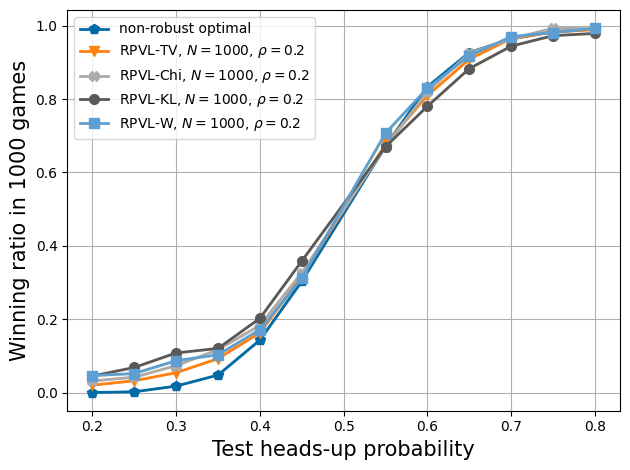

In [23]:
H = 50 # horizon
cardS = 50 # number of states in Gambler's Problem
rho = 0.2 # robustness parameter
p_o_h = 0.8 # change this to see other nominal model
N = 1000 # number of sample

pistar, Vstar = value_iteration_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H)
pihat_L1, Vhat_L1 = robust_emp_dp_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H, rho=rho, uncer='L1',
                                              num_samp=N)
pihat_Chi, Vhat_Chi = robust_emp_dp_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H, rho=rho, uncer='Chi',
                                                num_samp=N)
pihat_KL, Vhat_KL = robust_emp_dp_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H, rho=rho, uncer='KL',
                                              num_samp=N)
pihat_W, Vhat_W = robust_emp_dp_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H, rho=rho, 
                                   uncer='W', d=lambda x,y: abs(x-y), p=1, num_samp=N)

policies = [pistar, pihat_L1, pihat_Chi, pihat_KL, pihat_W]

# act policies on testing environments
head_p = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
n_runs = 1000
s_range = range(30)
win_ratio_seeds = np.zeros((len(s_range),len(head_p),len(policies)))
for s in s_range:
#     print("seed - ", s)
    win_percent_data = []
    for jj, p in enumerate(head_p):
        data_collect = []
        time_data_collect = []
        for n in range(n_runs):
            np.random.seed(s+n+50)
            temp = []
            temp_2 = []
            for j in range(len(policies)):
                reward, steps_time = run_policy(p, policies[j], max_states_plus_1 = cardS, max_steps = H)
                temp.append(reward)
                temp_2.append(steps_time)
            data_collect.append(temp)
            time_data_collect.append(temp_2)

        win_percent = np.mean(data_collect, axis=0)
        win_ratio_seeds[s,jj,:] = win_percent

mean_vals = np.mean(win_ratio_seeds, axis=0)
std_vals = np.std(win_ratio_seeds, axis=0)

# plot
markercycler = cycle(markers)
colorcycler = cycle(colors)
bandcycler = cycle(bands)
fig, ax = plt.subplots(1, 1)

labels = ['non-robust optimal', 'RPVL-TV'+r', $N=1000$, $\rho=0.2$', 'RPVL-Chi'+r', $N=1000$, $\rho=0.2$', 
          'RPVL-KL'+r', $N=1000$, $\rho=0.2$', 'RPVL-W'+r', $N=1000$, $\rho=0.2$']
for i in range(len(labels)):
    ax.plot(head_p, mean_vals[:,i], marker=next(markercycler), color=next(colorcycler), label=labels[i],
           linewidth=2, markersize=7)
    lower, upper = mean_vals[:,i] - std_vals[:,i], mean_vals[:,i] + std_vals[:,i]
    ax.fill_between(head_p, lower, upper, color=next(bandcycler))

ax.legend()
ax.grid(visible=True)
ax.set_ylabel("Winning ratio in 1000 games", fontsize=15)
ax.set_xlabel("Test heads-up probability", fontsize=15)

fig.tight_layout()

### The effect of robustness parameter $\rho$
Corresponds to Fig.1 (middle plot). This section is a comparison among the robust policies trained with different robustness parameter $\rho$. We include the Wasserstein case here with nominal model $p^o_h=0.6$ and number of sample $N=1000$.

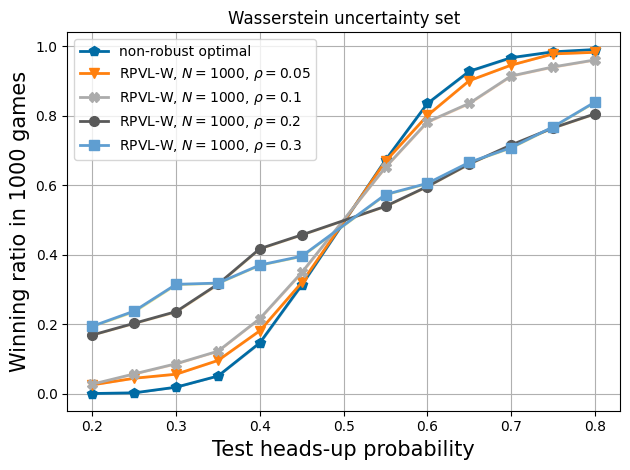

In [24]:
# wasserstein diff. rhos
H = 50
cardS = 50
rhos = [0.05, 0.1, 0.2, 0.3]
p_o_h = 0.6
N = 1000
pistar, Vstar = value_iteration_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H)
pihat_W_ls, Vhat_W_ls = [], []
for rho in rhos:
    pihat_W, Vhat_W = robust_emp_dp_for_gamblers(p_h=p_o_h, max_states_plus_1=cardS, horizon_l=H, rho=rho, 
                                       uncer='W', d=lambda x,y: abs(x-y), p=1, num_samp=N)
    pihat_W_ls.append(pihat_W)
    Vhat_W_ls.append(Vhat_W)
policies = [pistar, pihat_W_ls[0], pihat_W_ls[1], pihat_W_ls[2], pihat_W_ls[3]]

# evaluate the policies
head_p = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
n_runs = 1000
s_range = range(30)
win_ratio_seeds = np.zeros((len(s_range),len(head_p),len(policies)))
for s in s_range:
#     print("seed - ", s)
    win_percent_data = []
    for jj, p in enumerate(head_p):
        data_collect = []
        time_data_collect = []
        for n in range(n_runs):
            np.random.seed(s+n+50)
            temp = []
            temp_2 = []
            for j in range(len(policies)):
                reward, steps_time = run_policy(p, policies[j], max_states_plus_1 = cardS, max_steps = H)
                temp.append(reward)
                temp_2.append(steps_time)
            data_collect.append(temp)
            time_data_collect.append(temp_2)

        win_percent = np.mean(data_collect, axis=0)
        win_ratio_seeds[s,jj,:] = win_percent

mean_vals = np.mean(win_ratio_seeds, axis=0)
std_vals = np.std(win_ratio_seeds, axis=0)

# plot
markercycler = cycle(markers)
colorcycler = cycle(colors)
bandcycler = cycle(bands)
fig_W, ax_W = plt.subplots(1, 1)
labels = ['non-robust optimal', 'RPVL-W'+r', $N=1000$, $\rho=0.05$', 'RPVL-W'+r', $N=1000$, $\rho=0.1$', 
          'RPVL-W'+r', $N=1000$, $\rho=0.2$', 'RPVL-W'+r', $N=1000$, $\rho=0.3$']
for i in range(len(labels)):
    ax_W.plot(head_p, mean_vals[:,i], marker=next(markercycler), color=next(colorcycler), label=labels[i],
              linewidth=2, markersize=7)
    lower, upper = mean_vals[:,i] - std_vals[:,i], mean_vals[:,i] + std_vals[:,i]
    ax_W.fill_between(head_p, lower, upper, color=next(bandcycler))

ax_W.legend()
ax_W.grid(visible=True)
ax_W.set_ylabel("Winning ratio in 1000 games", fontsize=15)
ax_W.set_xlabel("Test heads-up probability", fontsize=15)
ax_W.set_title("Wasserstein uncertainty set")
fig_W.tight_layout()

### Sub-optimality gap vs. number of samples N
Corresponds to Fig. 1 (left plot) in the paper. This section studies the convergence of robust policy (in terms of sub-optimality gap) with respect to number of samples N.

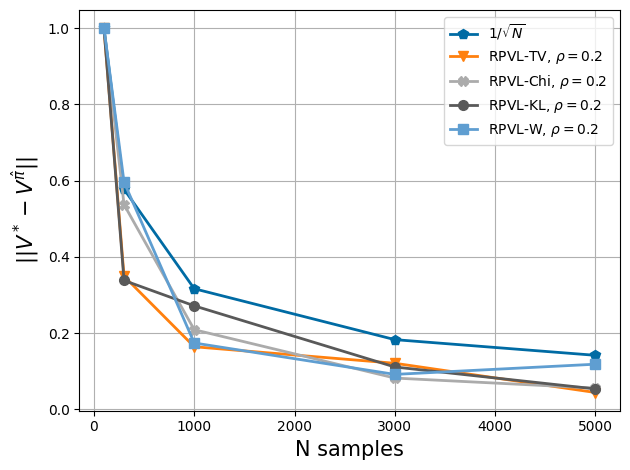

In [29]:
# train policies with different number of samples N
Ns = [100, 300, 1000, 3000, 5000]
pihat_TV_ls, Vhat_TV_ls = [], []
for N in Ns:
    pihat_TV, Vhat_TV = robust_emp_dp_for_gamblers(p_h=0.6, max_states_plus_1=cardS, horizon_l=H, rho=0.2, 
                                                   uncer='L1', num_samp=N)
    pihat_TV_ls.append(pihat_TV)
    Vhat_TV_ls.append(Vhat_TV)
    
pihat_Chi_ls, Vhat_Chi_ls = [], []
for N in Ns:
    pihat_Chi, Vhat_Chi = robust_emp_dp_for_gamblers(p_h=0.6, max_states_plus_1=cardS, horizon_l=H, rho=0.2, 
                                                     uncer='Chi', num_samp=N)
    pihat_Chi_ls.append(pihat_Chi)
    Vhat_Chi_ls.append(Vhat_Chi)
    
pihat_KL_ls, Vhat_KL_ls = [], []
for N in Ns:
    pihat_KL, Vhat_KL = robust_emp_dp_for_gamblers(p_h=0.6, max_states_plus_1=cardS, horizon_l=H, rho=0.2, 
                                                   uncer='KL', num_samp=N)
    pihat_KL_ls.append(pihat_KL)
    Vhat_KL_ls.append(Vhat_KL)    

pihat_W_ls, Vhat_W_ls = [], []
for N in Ns:
    pihat_W, Vhat_W = robust_emp_dp_for_gamblers(p_h=0.6, max_states_plus_1=cardS, horizon_l=H, rho=0.2, 
                                                 uncer='W', d=lambda x,y: abs(x-y), p=1, num_samp=N)
    pihat_W_ls.append(pihat_W)
    Vhat_W_ls.append(Vhat_W)
    
# policy evaluation using robust bellman consistency equation
# TV
V_1_opt_TV = Vopt_L1[:,0]
s_range = range(1)
mean_N_TV_ls, std_N_TV_ls = [], []
for pi in pihat_TV_ls:
    subopt_gap_ls = []
    for s in s_range:
        np.random.seed(s+10000)
        _, subopt_gap = policy_evaluation(pi, V_1_opt_TV, uncer='L1')
        subopt_gap_ls.append(subopt_gap)
    mean_N_TV_ls.append(np.mean(subopt_gap_ls))
    std_N_TV_ls.append(np.std(subopt_gap_ls))
    
# Chi
V_1_opt_Chi = Vopt_Chi[:,0]
s_range = range(1)
mean_N_Chi_ls, std_N_Chi_ls = [], []
for pi in pihat_Chi_ls:
    subopt_gap_ls = []
    for s in s_range:
        np.random.seed(s+10000)
        _, subopt_gap = policy_evaluation(pi, V_1_opt_Chi, uncer='Chi')
        subopt_gap_ls.append(subopt_gap)
    mean_N_Chi_ls.append(np.mean(subopt_gap_ls))
    std_N_Chi_ls.append(np.std(subopt_gap_ls))
    
# KL
V_1_opt_KL = Vopt_KL[:,0]
s_range = range(1)
mean_N_KL_ls, std_N_KL_ls = [], []
for pi in pihat_KL_ls:
    subopt_gap_ls = []
    for s in s_range:
        np.random.seed(s+10000)
        _, subopt_gap = policy_evaluation(pi, V_1_opt_KL, uncer='KL')
        subopt_gap_ls.append(subopt_gap)
    mean_N_KL_ls.append(np.mean(subopt_gap_ls))
    std_N_KL_ls.append(np.std(subopt_gap_ls))
    
# W
V_1_opt_W = Vopt_W[:,0]
s_range = range(10)
mean_N_W_ls, std_N_W_ls = [], []
for pi in pihat_W_ls:
    subopt_gap_ls = []
    for s in s_range:
        np.random.seed(s+10000)
        _, subopt_gap = policy_evaluation(pi, V_1_opt_W, uncer='W', d=lambda x,y: abs(x-y), p=1)
        subopt_gap_ls.append(subopt_gap)
    mean_N_W_ls.append(np.mean(subopt_gap_ls))
    std_N_W_ls.append(np.std(subopt_gap_ls))

# normalize data
def fun(x):
    return 1 / np.sqrt(x)
N_vals = [fun(n) for n in Ns]

def normalize_fun(data):
    return data / np.max(data)
mean_N_TV_norm = normalize_fun(mean_N_TV_ls)
mean_N_Chi_norm = normalize_fun(mean_N_Chi_ls)
mean_N_KL_norm = normalize_fun(mean_N_KL_ls)
mean_N_W_norm = normalize_fun(mean_N_W_ls)
N_vals_norm = normalize_fun(N_vals)

# plot
markercycler = cycle(markers)
colorcycler = cycle(colors)
bandcycler = cycle(bands)
fig_N, ax_N = plt.subplots(1,1, figsize= [6.4, 4.8])
ax_N.plot(Ns, N_vals_norm, marker=next(markercycler), color=next(colorcycler), label=r'$1/\sqrt{N}$',
         linewidth=2, markersize=7)
ax_N.plot(Ns, mean_N_TV_norm, marker=next(markercycler), color=next(colorcycler), label='RPVL-TV'+r', $\rho=0.2$',
          linewidth=2, markersize=7)
ax_N.plot(Ns, mean_N_Chi_norm, marker=next(markercycler), color=next(colorcycler), label='RPVL-Chi'+r', $\rho=0.2$',
         linewidth=2, markersize=7)
ax_N.plot(Ns, mean_N_KL_norm, marker=next(markercycler), color=next(colorcycler), label='RPVL-KL'+r', $\rho=0.2$',
         linewidth=2, markersize=7)
ax_N.plot(Ns, mean_N_W_norm, marker=next(markercycler), color=next(colorcycler), label='RPVL-W'+r', $\rho=0.2$',
         linewidth=2, markersize=7)
ax_N.legend()
ax_N.grid(visible=True)
ax_N.set_xlabel("N samples", fontsize=15)
ax_N.set_ylabel(r"$||V^* - V^{\hat{\pi}}||$", fontsize=15)
fig_N.tight_layout()

### Sub-optimality gap vs. robustness parameter $\rho$
In proving the main theorem of the paper, we find that the upper bound of suboptimality gap is some function of $\rho$, i.e., of order $\frac{1}{\rho}$ for TV, KL, and Wasserstein and of order $\frac{\rho+1}{\sqrt{r+1}-1}$ for chi-square. Here, we aim to verify this through experiment.

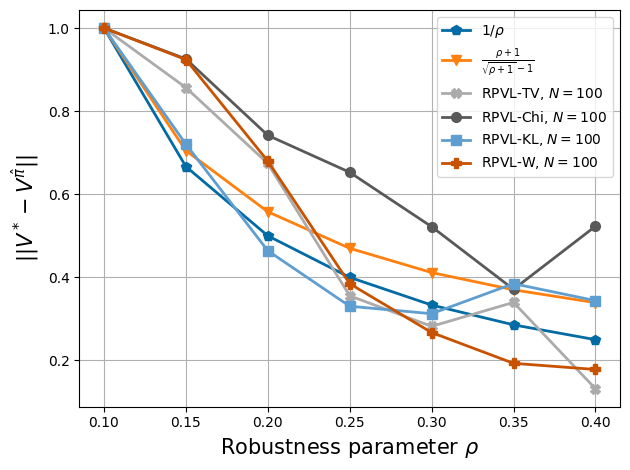

In [28]:
# train policies
rhos = [0.1,0.15,0.2,0.25,0.3,0.35,0.4]
N = 100
p_o_h = 0.6
pihat_TV_rho_ls, Vhat_TV_rho_ls = [], []
for rho in rhos:
    pihat_TV, Vhat_TV = robust_emp_dp_for_gamblers(p_h=0.6, max_states_plus_1=cardS, horizon_l=H, rho=rho, 
                                                   uncer='L1', num_samp=N)
    pihat_TV_rho_ls.append(pihat_TV)
    Vhat_TV_rho_ls.append(Vhat_TV)
    
pihat_Chi_rho_ls, Vhat_Chi_rho_ls = [], []
for rho in rhos:
    pihat_Chi, Vhat_Chi = robust_emp_dp_for_gamblers(p_h=0.6, max_states_plus_1=cardS, horizon_l=H, rho=rho, 
                                                   uncer='Chi', num_samp=N)
    pihat_Chi_rho_ls.append(pihat_Chi)
    Vhat_Chi_rho_ls.append(Vhat_Chi)
    
pihat_KL_rho_ls, Vhat_KL_rho_ls = [], []
for rho in rhos:
    pihat_KL, Vhat_KL = robust_emp_dp_for_gamblers(p_h=0.6, max_states_plus_1=cardS, horizon_l=H, rho=rho, 
                                                   uncer='KL', num_samp=N)
    pihat_KL_rho_ls.append(pihat_KL)
    Vhat_TV_rho_ls.append(Vhat_KL)  

pihat_W_rho_ls, Vhat_W_rho_ls = [], []
for rho in rhos:
    pihat_W, Vhat_W = robust_emp_dp_for_gamblers(p_h=0.6, max_states_plus_1=cardS, horizon_l=H, rho=rho, 
                                                   uncer='W', d=lambda x,y: abs(x-y), p=1, num_samp=N)
    pihat_W_rho_ls.append(pihat_W)
    Vhat_W_rho_ls.append(Vhat_W)
    
# policy evaluation
# # TV
V_1_opt_TV = Vopt_L1[:,0]
suboptgap_rho_TV = []
for pi in pihat_TV_rho_ls:
    _, subopt_gap = policy_evaluation(pi, V_1_opt_TV, uncer='L1')
    suboptgap_rho_TV.append(subopt_gap)

# Chi
V_1_opt_Chi = Vopt_Chi[:,0]
suboptgap_rho_Chi = []
for pi in pihat_Chi_rho_ls:
    _, subopt_gap = policy_evaluation(pi, V_1_opt_Chi, uncer='Chi')
    suboptgap_rho_Chi.append(subopt_gap)
    
# KL
V_1_opt_KL = Vopt_KL[:,0]
suboptgap_rho_KL = []
for pi in pihat_KL_rho_ls:
    _, subopt_gap = policy_evaluation(pi, V_1_opt_KL, uncer='KL')
    suboptgap_rho_KL.append(subopt_gap)
    
# W
V_1_opt_W = Vopt_W[:,0]
suboptgap_rho_W = []
for pi in pihat_W_rho_ls:
    _, subopt_gap = policy_evaluation(pi, V_1_opt_W, uncer='W', d=lambda x,y: abs(x-y), p=1)
    suboptgap_rho_W.append(subopt_gap)

# refernce functions
def fun1(rho):
    return 1 / rho
vals_rho = [fun1(rho) for rho in rhos]

def fun2(rho):
    return (rho+1) / (np.sqrt(rho+1)-1)
vals_rho_chi = [fun2(rho) for rho in rhos]

# normalize data
suboptgap_rho_TV_norm = normalize_fun(suboptgap_rho_TV)
suboptgap_rho_Chi_norm = normalize_fun(suboptgap_rho_Chi)
suboptgap_rho_KL_norm = normalize_fun(suboptgap_rho_KL)
suboptgap_rho_W_norm = normalize_fun(suboptgap_rho_W)
fun1_norm = normalize_fun(vals_rho)
fun2_norm = normalize_fun(vals_rho_chi)

# plot
fig_rho, ax_rho = plt.subplots(1,1)
markercycler = cycle(markers)
colorcycler = cycle(colors)
bandcycler = cycle(bands)

ax_rho.plot(rhos, fun1_norm, marker=next(markercycler), color=next(colorcycler), label=r'$1/\rho$',
         linewidth=2, markersize=7)
ax_rho.plot(rhos, fun2_norm, marker=next(markercycler), color=next(colorcycler), label=r'$\frac{\rho+1}{\sqrt{\rho+1}-1}$',
         linewidth=2, markersize=7)
ax_rho.plot(rhos, suboptgap_rho_TV_norm, marker=next(markercycler), color=next(colorcycler), label='RPVL-TV'+r', $N=100$',
          linewidth=2, markersize=7)
ax_rho.plot(rhos, suboptgap_rho_Chi_norm, marker=next(markercycler), color=next(colorcycler), label='RPVL-Chi'+r', $N=100$',
         linewidth=2, markersize=7)
ax_rho.plot(rhos, suboptgap_rho_KL_norm, marker=next(markercycler), color=next(colorcycler), label='RPVL-KL'+r', $N=100$',
         linewidth=2, markersize=7)
ax_rho.plot(rhos, suboptgap_rho_W_norm, marker=next(markercycler), color=next(colorcycler), label='RPVL-W'+r', $N=100$',
         linewidth=2, markersize=7)

ax_rho.legend()
ax_rho.grid(visible=True)
ax_rho.set_xlabel("Robustness parameter " + r'$\rho$', fontsize=15)
ax_rho.set_ylabel(r"$||V^* - V^{\hat{\pi}}||$", fontsize=15)
fig_rho.tight_layout()